In [156]:
%load_ext autoreload
%autoreload

In [157]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import color.data.embeddings as emb_data

In [158]:
# Get colors dataset
from color.data import colors_small
colors = colors_small.load_color_names()

In [4]:
# Get embeddings
vocab, emb = emb_data.load_embeddings(size=50)

In [159]:
# Index vocabulary
vocab_dict = {v:i for i,v in enumerate(vocab)}

In [161]:
# Converts a sentence to corresponding embeddings vectors
def to_embeddings(sentence, all_emb):
    words = sentence.split()
    emb = []
    for w in words:
        if w in vocab_dict:
            e = all_emb[vocab_dict[w]]
        else:
            # Assign random embedding to unknown words
            e = np.random.rand(50) - 0.5
        emb.append(e)
    return np.array(emb).astype(np.float)
x = to_embeddings('hi my name is zuzuzu', emb)
x.shape

(5, 50)

In [164]:
# Dataset for training
class ColorsDataset(D.Dataset):
    
    def __init__(self, colors, emb):
        # Colors should be in [0, 1]
        col = colors[['r', 'g', 'b']].values.astype(np.int) / 256
        self.rgb = torch.from_numpy(col).float()

        color_emb = colors['name'].apply(
            lambda name: to_embeddings(name.lower(), emb))
        self.emb = list(map(lambda e: torch.from_numpy(e).float(), color_emb))
    
    def __len__(self):
        assert len(self.rgb) == len(self.emb)
        return len(self.rgb)
    
    def __getitem__(self, idx):
        return self.rgb[idx], self.emb[idx]
ds = ColorsDataset(colors, emb)

In [165]:
# Batch size restricted to 1 for now
dataloader = D.DataLoader(ds, batch_size=1, shuffle=True, num_workers=4)

In [52]:
# LSTM model that predicts rgb values at the final time step
class WordModel(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, color_dim):
        super(WordModel, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, color_dim)
    
    def forward(self, emb):
        emb = emb.view(emb.shape[1], 1, -1)
        lstm_out, _ = self.lstm(emb)
        final_out = lstm_out[-1]
        linear_out = self.linear(final_out)
        return torch.sigmoid(linear_out)

In [167]:
# Just checking
m = WordModel(50, 30, 3)
di = iter(dataloader)
c, e = di.next()
t = m(e)
l = nn.MSELoss()
l(c, t)

tensor(0.0268, grad_fn=<MeanBackward1>)

In [97]:
# Train
num_epochs = 50
model = WordModel(50, 50, 3)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
losses = []

for epoch in range(num_epochs):
    for i, (rgb, embedding) in enumerate(dataloader):
        model.zero_grad()
        rgb_preds = model(embedding)
        loss = loss_fn(rgb, rgb_preds)
        loss.backward()
        optimizer.step()
    print('Epoch Complete : {}'.format(epoch+1))
    losses.append(loss.detach().numpy())

Epoch Complete : 1
Epoch Complete : 2
Epoch Complete : 3
Epoch Complete : 4
Epoch Complete : 5
Epoch Complete : 6
Epoch Complete : 7
Epoch Complete : 8
Epoch Complete : 9
Epoch Complete : 10
Epoch Complete : 11
Epoch Complete : 12
Epoch Complete : 13
Epoch Complete : 14
Epoch Complete : 15
Epoch Complete : 16
Epoch Complete : 17
Epoch Complete : 18
Epoch Complete : 19
Epoch Complete : 20
Epoch Complete : 21
Epoch Complete : 22
Epoch Complete : 23
Epoch Complete : 24
Epoch Complete : 25
Epoch Complete : 26
Epoch Complete : 27
Epoch Complete : 28
Epoch Complete : 29
Epoch Complete : 30
Epoch Complete : 31
Epoch Complete : 32
Epoch Complete : 33
Epoch Complete : 34
Epoch Complete : 35
Epoch Complete : 36
Epoch Complete : 37
Epoch Complete : 38
Epoch Complete : 39
Epoch Complete : 40
Epoch Complete : 41
Epoch Complete : 42
Epoch Complete : 43
Epoch Complete : 44
Epoch Complete : 45
Epoch Complete : 46
Epoch Complete : 47
Epoch Complete : 48
Epoch Complete : 49
Epoch Complete : 50


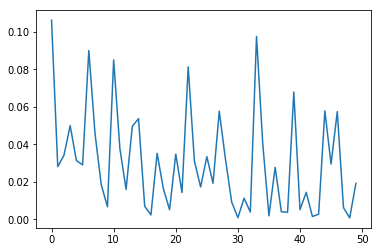

In [169]:
# Plot loss per iteration (should be going down)
losses = np.array(losses)
plt.plot(np.arange(len(losses)), losses)

[0.5155074596405029, 0.37771108746528625, 0.3253866732120514]


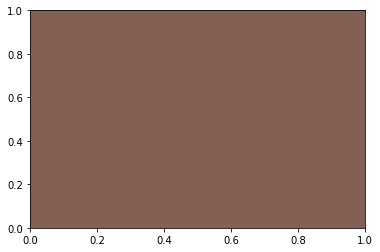

In [193]:
# Runs a new color name throught the model to predict its color
def predict(model, color_name):
    with torch.no_grad():
        e = torch.from_numpy(to_embeddings(color_name, emb).astype(np.float)).float()
        rgb = model(e.view(1, e.shape[0], -1))
        color = rgb.numpy().reshape(-1).tolist()
        return color
color = predict(model, 'brown')
print(color)
p = patches.Rectangle((0,0), 5, 5, color=color)
fig,ax = plt.subplots(1)
ax.add_patch(p)

In [233]:
def pred_and_plot(color_names):
    fig = plt.figure(figsize=(15, 2))
    ax = fig.add_subplot(111)
    total_width = 400
    total_height = 200
    col_width = total_width / len(color_names)
    for i, cn in enumerate(color_names):
        pred = predict(model, cn)
        p = patches.Rectangle((col_width*i,0), total_width, total_height, color=pred)
        ax.add_patch(p)
        ax.text(col_width*(i+0.25),total_height/2, cn)
    plt.xlim([0, total_width])
    plt.ylim([0, total_height])


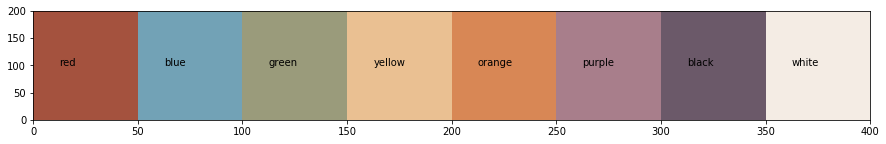

In [234]:
pred_and_plot(['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'black', 'white'])


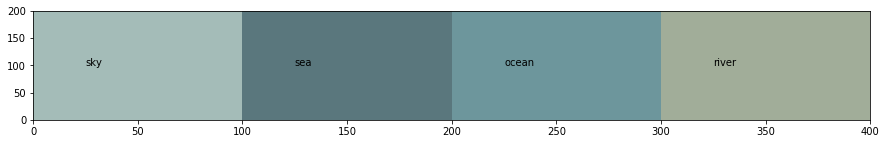

In [235]:
pred_and_plot(['sky', 'sea', 'ocean', 'river'])

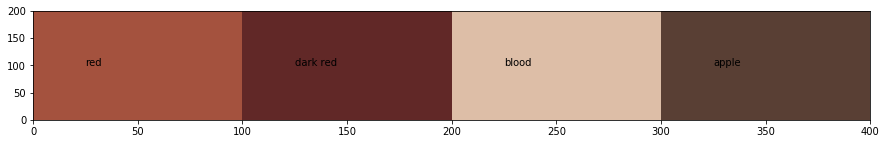

In [236]:
pred_and_plot(['red', 'dark red', 'blood', 'apple'])